# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
X_train_ = pd.read_csv('data/X_train.csv', index_col=[0,1])
X_test = pd.read_csv('data/X_test.csv', index_col=[0,1])

In [19]:
y_train_ = pd.read_csv('data/y_train.csv', index_col=[0])
y_test = pd.read_csv('data/y_test.csv', index_col=[0])

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_, y_train_, test_size=.25, random_state=42)

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [41]:
clf = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
importances = clf.feature_importances_

sorted_indices = np.argsort(importances)
features = np.array(X_train.columns)[[sorted_indices[-3:]]]

features

array([['tGravityAcc-mean()-Y', 'fBodyAcc-mean()-X',
        'tGravityAcc-min()-X']], dtype=object)

### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [47]:
X_train_best = X_train.iloc[:,sorted_indices[-3:]]
X_valid_best = X_valid.iloc[:,sorted_indices[-3:]]
X_test_best = X_test.iloc[:,sorted_indices[-3:]]

In [49]:
%%time
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train_best, y_train)
ccp_alphas = path.ccp_alphas

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha).fit(X_train_best, y_train)
    clfs.append(clf)

CPU times: user 2.75 s, sys: 15.1 ms, total: 2.76 s
Wall time: 2.76 s


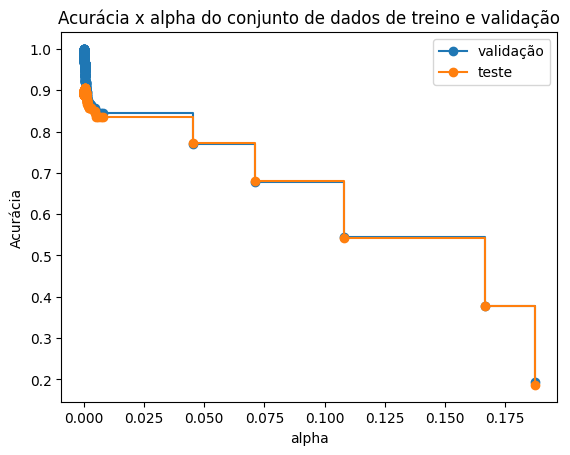

In [50]:
train_scores = [clf.score(X_train_best, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid_best, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [54]:
index_clf = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
best_clf = clfs[index_clf]
best_clf

DecisionTreeClassifier(ccp_alpha=0.0005951792132423253, random_state=42)

### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

In [73]:
activity_label = pd.read_csv('data/UCI HAR Dataset/activity_labels.txt', delim_whitespace=True, header=None, index_col=[0], names=['Index', 'Activity'])
activity_label.iloc[:,0].values

array(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING',
       'STANDING', 'LAYING'], dtype=object)

Acurácia: 71.63


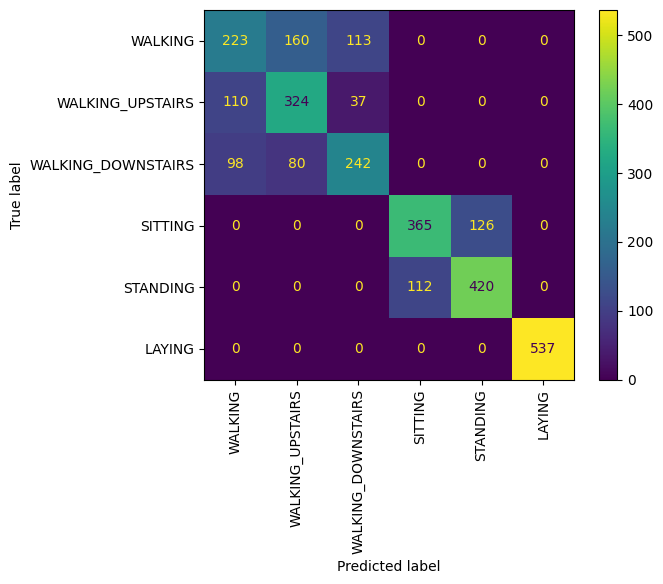

In [74]:
score = best_clf.score(X_test_best, y_test)

print(f'Acurácia: {score*100:.2f}')
cm = confusion_matrix(y_test, best_clf.predict(X_test_best))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_label.iloc[:,0].values).plot()
plt.xticks(rotation=90);